In [20]:
import tensorflow as tf
import pandas as pd
import numpy as np
from playlist_recommender.modelling import model_pipeline, utils
import joblib
import json
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from collections import Counter

In [21]:
def get_top_n_prediction_indices(prediction_array:np.array, n:int):
    return np.flip(np.argsort(prediction_array)[-n:])

In [54]:
def get_top_n_prediction_probas(prediction_array:np.array, n:int):
    return sorted(prediction_array, reverse = True)[:n]

In [22]:
def make_prediction(model, row, le_dict:dict):
    return le_dict[str(np.argmax(model.predict(row)))]   

In [23]:
def get_top_n_predictions(prediction_array:np.array, n:int, encoder_dict:dict):
    top_indices = get_top_n_prediction_indices(prediction_array, n)
    predictions_list = []
    for idx in top_indices:
       predictions_list.append(encoder_dict[str(idx)])
    return predictions_list

In [24]:
trained_model_dir = r"/Users/jamesmoro/Documents/Python/playlist-recommender/playlist_recommender/modelling/trained_nn_model"

In [25]:
model = tf.keras.models.load_model(trained_model_dir)

In [26]:
liked_songs_dir = r"/Users/jamesmoro/Documents/Python/playlist-recommender/playlist_recommender/data/liked_songs_df.pkl"
liked_songs = pd.read_pickle(liked_songs_dir)

In [27]:
liked_artists = liked_songs['artist_names'].to_list()
liked_tracks = liked_songs['track_names'].to_list()
zipped_artists_tracks = tuple(zip(liked_artists, liked_tracks))

In [28]:
pipeline = joblib.load("pipeline.pkl")

In [30]:
json_dir = r"/Users/jamesmoro/Documents/Python/playlist-recommender/playlist_recommender/modelling/label_encoding.json"
with open(json_dir, 'r') as f:
  le_dict = json.load(f)

In [31]:
transformed = pipeline.transform(liked_songs)

In [38]:
predictions = model.predict(transformed)

21/21 [==============================] - 0s 5ms/step


In [40]:
top_1_predicted_labels = []
for array in predictions:
    _predictions_labels = get_top_n_predictions(array, 1, le_dict)
    top_1_predicted_labels.append(_predictions_labels)
top_1_predictions_dict = dict(zip(zipped_artists_tracks, top_1_predicted_labels))     

In [41]:
top_1_predictions_values = list(
        itertools.chain.from_iterable(list(top_1_predictions_dict.values()))) 

<AxesSubplot:xlabel='count'>

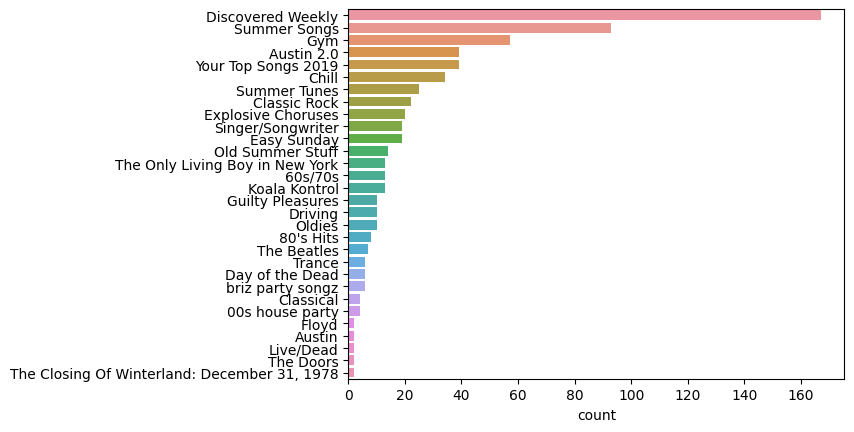

In [42]:
# fig, ax = plt.subplots(figsize = (12,8))
counts = Counter(top_1_predictions_values)
top_1_predictions_values = sorted(top_1_predictions_values, key=counts.get, reverse=True)
sns.countplot(y = top_1_predictions_values, orient= 'h',)


In [91]:
df = pd.DataFrame()
first = []
first_proba = []
second = []
second_proba = []
third = []
third_proba = []
for idx in predictions:
     first.append(le_dict[str(get_top_n_prediction_indices(idx, 1).item(0))])
     first_proba.append(get_top_n_prediction_probas(idx, n = 1)[0])
     second.append(le_dict[str(get_top_n_prediction_indices(idx, 2).item(1))])
     second_proba.append(get_top_n_prediction_probas(idx, n = 2)[1])
     third.append(le_dict[str(get_top_n_prediction_indices(idx, 3).item(2))])
     third_proba.append(get_top_n_prediction_probas(idx, n = 3)[2])

In [94]:
df['artist name'] = liked_artists
df['track name'] = liked_tracks
df['first prediction'] = first
df['first prediction proba']  = first_proba
df['second prediction'] = second
df['second prediction proba'] = second_proba
df['third prediction'] = third
df['third prediction proba'] = third_proba

In [96]:
df.head()

,first prediction,first prediction proba,second prediction,second prediction proba,third prediction,third prediction proba,artist name,track name
0,80's Hits,0.418713,Guilty Pleasures,0.206965,Explosive Choruses,0.122676,Elton John,All The Girls Love Alice - Remastered 2014
1,Discovered Weekly,0.439811,Your Top Songs 2019,0.115579,Singer/Songwriter,0.106167,Brian Protheroe,Pinball
2,Austin 2.0,0.299474,Discovered Weekly,0.143244,Chill,0.139716,Lo Moon,Dream Never Dies
3,Summer Songs,0.793423,Classic Rock,0.071341,Discovered Weekly,0.039862,Nation of Language,Across That Fine Line
4,Explosive Choruses,0.171281,Old Summer Stuff,0.134715,Summer Songs,0.132232,Harvey Danger,Flagpole Sitta


In [100]:
df[df['first prediction'] == 'Summer Songs'].sort_values(
    by = 'first prediction proba',
    ascending = False).head()

,first prediction,first prediction proba,second prediction,second prediction proba,third prediction,third prediction proba,artist name,track name
88,Summer Songs,0.959359,Old Summer Stuff,0.017071,60s/70s,0.006212,Morgan Delt,Some Sunsick Day
594,Summer Songs,0.957038,60s/70s,0.009298,Classic Rock,0.008400,The Lovin' Spoonful,Summer In The City
121,Summer Songs,0.928586,60s/70s,0.022059,Old Summer Stuff,0.015333,MGMT,Little Dark Age
177,Summer Songs,0.922730,Old Summer Stuff,0.039095,60s/70s,0.008118,Leon Bridges,If It Feels Good (Then It Must Be)
630,Summer Songs,0.921502,Old Summer Stuff,0.048949,Guilty Pleasures,0.008722,Mark Ronson,Uptown Funk (feat. Bruno Mars)
